In [ ]:
%%capture
!pip install -r requirements.txt

In [16]:
import numpy as np
from scenedetect import detect, AdaptiveDetector, detect
from qdrant_client import QdrantClient, models
from transformers import AutoProcessor, AutoModel
import torch
from typing import Union
import cv2
import matplotlib.pyplot as plt
import uuid
from IPython.display import clear_output


  
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
CONFIG = {
    "collection_name" : "search_image_2025",
    "clip_model": "openai/clip-vit-large-patch14",
    "video_path" : "data/60S SANG 12_09_2025 HTV TIN TUC.mp4" # Change to the video you needed
}

# Detect the screen

In [ ]:
def detect_screen(video_path: str):
    detector = AdaptiveDetector()
    scene_list = detect(video_path, detector)

    scenes_data = {}
    for i, scene in enumerate(scene_list):
        start_time, end_time = scene

        scenes_data[i] = {
            "start_seconds": start_time.get_seconds(),
            "frame_idx" : i,
            "end_seconds": end_time.get_seconds(),
            "start_frame": start_time.get_frames(),
            "end_frame": end_time.get_frames(),
            "duration_seconds": (end_time - start_time).get_seconds(),
            "video_path" : video_path,
        }

    return scenes_data

# Build a vector store 

In [ ]:
qdrant_client = QdrantClient(host="localhost")

qdrant_client.create_collection(
    collection_name=CONFIG["collection_name"],
    vectors_config = models.VectorParams(size=768, distance=models.Distance.COSINE),
)

## Methods that will come in handy for working with a vector store

In [ ]:
model = AutoModel.from_pretrained(CONFIG["clip_model"])
processor = AutoProcessor.from_pretrained(CONFIG["clip_model"])

def to_embedding(input_obj : Union[str, np.ndarray]): # np.array = image
  model.to(device)

  outputs = None
  with torch.no_grad():
    if isinstance(input_obj, str):
      inputs = processor(text=input_obj, return_tensors="pt", padding=True, truncation=True).to(device)
      outputs = model.get_text_features(**inputs)
    if isinstance(input_obj, np.ndarray):
      inputs = processor(images=input_obj, return_tensors="pt", padding=True).to(device)
      outputs = model.get_image_features(**inputs)

  if outputs is None:
    print("No output.")
    return np.array([])

  # Normalize the embeddings for better cosine similarity
  embedding = outputs.cpu().numpy().flatten()
  norm = np.linalg.norm(embedding)
  if norm > 0:
    embedding = embedding / norm
  
  return embedding

In [ ]:
def get_image_from_idx(video_path, frame_idx):
  cap = cv2.VideoCapture(video_path)
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
  ret, frame = cap.read()
  cap.release()
  return frame

In [ ]:
def insert_frames(scenes_data: dict[dict]):
    points = []
    for frame_idx, frame_data in scenes_data.items():
        middle_frame = (frame_data["start_frame"] + frame_data["end_frame"]) // 2
        images = get_image_from_idx(frame_data["video_path"], middle_frame)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB) # Convert for clip model
        image_features = to_embedding(images)
        
        frame_data["extracted_frame"] = middle_frame
        
        points.append(
            models.PointStruct(
                id=str(uuid.uuid4()),
                payload=frame_data,
                vector=image_features,
            ),
        )

    qdrant_client.upsert(collection_name=CONFIG["collection_name"], points=points)

In [ ]:
def search_image(user_query: str, top_k: int = 5):
    query_embedding = to_embedding(user_query)

    results = qdrant_client.query_points(
        collection_name=CONFIG["collection_name"],
        query=query_embedding,
        limit=top_k,
    )
    return results.points

In [ ]:
def display_image(video_path: str, frame_idx: int):
    frame_to_display = get_image_from_idx(video_path, frame_idx)

    if frame_to_display is not None:
        frame_rgb = cv2.cvtColor(frame_to_display, cv2.COLOR_BGR2RGB)

        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.show()
    else:
        print("Could not retrieve the frame.")

# Main flowwww

In [ ]:
# Flow
scenes_data = detect_screen(CONFIG["video_path"])
print("Get the sreen complete.")

In [ ]:
insert_frames(scenes_data)
print("Embedding complete.")

In [ ]:
# Search
user_query = input("Enter your query: ")
results = search_image(user_query)
for point in results:
    try:
        # Use the actual extracted frame number, not the scene index
        extracted_frame = point.payload.get("extracted_frame", point.payload.get("frame_idx", 0))
        start_time_minutes = point.payload["start_seconds"] / 60
        print(f"Found result at {start_time_minutes:.2f}min, frame: {extracted_frame}, score: {point.score:.4f}")
        display_image(CONFIG["video_path"], extracted_frame)
    except Exception as e:
        print(f"Error retrieving or displaying frame for ID {point.id}: {e}")
        

Found result at 2.73min, frame: 4140, score: 0.2917


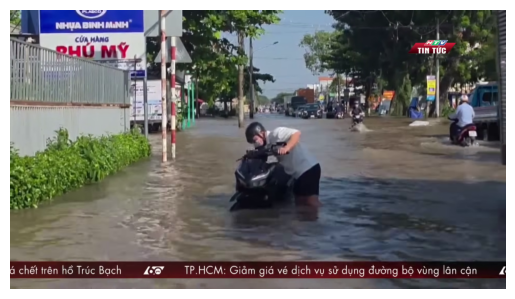

Found result at 1.05min, frame: 1618, score: 0.2657


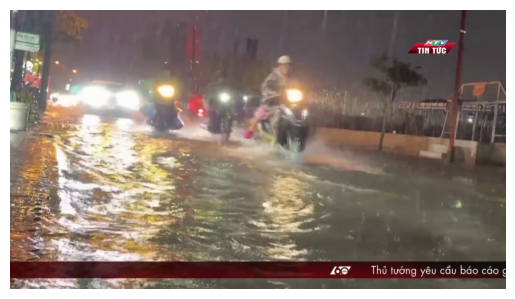

Found result at 3.52min, frame: 5302, score: 0.2515


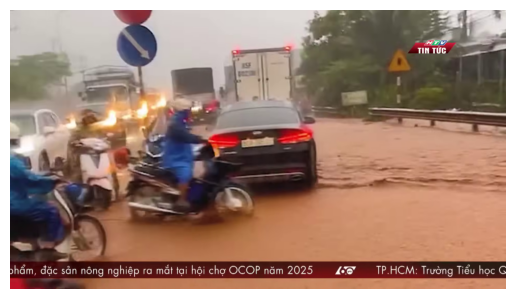

Found result at 3.46min, frame: 5236, score: 0.2434


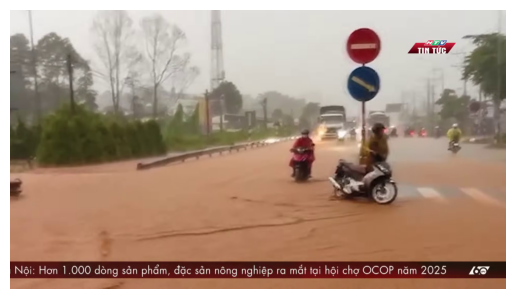

Found result at 0.32min, frame: 500, score: 0.2426


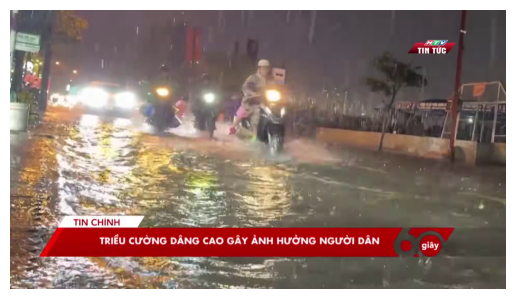

In [ ]:
while True:
  try:
    user_query = input("Enter your query: ")
    results = search_image(user_query)
    for point in results:
        try:
            # Use the actual extracted frame number, not the scene index
            extracted_frame = point.payload.get("extracted_frame", point.payload.get("frame_idx", 0))
            start_time_minutes = point.payload["start_seconds"] / 60
            print(f"Found result at {start_time_minutes:.2f}min, frame: {extracted_frame}, score: {point.score:.4f}")
            
            
            display_image(CONFIG["video_path"], extracted_frame)
        except Exception as e:
            print(f"Error retrieving or displaying frame for ID {point.id}: {e}")
  except KeyboardInterrupt:
    break
  finally:
    clear_output(wait=True)